In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os

# Define dataset paths
data_dir = "C:\\Users\\HP\\Documents\\major_project\\Data_set\\final_datasets\\final_datasetsssss"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "validation")

# Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Standard Transform for Test/Validation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained DenseNet121 model
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier.in_features

# Add Dropout
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(train_dataset.classes))
)

model = model.to(device)

# Define loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=5):
    best_val_acc = 0.0
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100 * correct / total
        val_acc, val_loss = evaluate_model(model, val_loader, criterion)
        
        # Learning rate scheduler step
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}: Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_densenet_model.pth")  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break
    
    return model

# Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return accuracy, avg_loss

# Train and evaluate
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5)
model.load_state_dict(torch.load("best_densenet_model.pth"))  # Load best model
test_accuracy, _ = evaluate_model(model, test_loader, criterion)
print(f'Test Accuracy: {test_accuracy:.2f}%')


C:\Users\HP\anaconda3\python\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Loss: 0.4545, Train Acc: 80.57%, Val Acc: 97.38%
Epoch 2: Loss: 0.2040, Train Acc: 92.16%, Val Acc: 98.03%
Epoch 3: Loss: 0.1561, Train Acc: 94.29%, Val Acc: 97.87%
Epoch 4: Loss: 0.1350, Train Acc: 95.09%, Val Acc: 98.36%
Epoch 5: Loss: 0.1297, Train Acc: 95.33%, Val Acc: 98.36%
Epoch 6: Loss: 0.1246, Train Acc: 95.21%, Val Acc: 97.21%
Epoch 7: Loss: 0.1057, Train Acc: 96.29%, Val Acc: 98.20%
Epoch 8: Loss: 0.0984, Train Acc: 96.15%, Val Acc: 98.36%
Epoch 9: Loss: 0.0996, Train Acc: 96.17%, Val Acc: 98.20%
Early stopping triggered.


C:\Users\HP\AppData\Local\Temp\ipykernel_4856\1857961084.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_densenet_model.pth"))  

Test Accuracy: 97.06%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os

# Define dataset paths
data_dir = "C:\\Users\\HP\\Documents\\major_project\\Data_set\\final_datasets\\final_datasetsssss"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "validation")

# Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Standard Transform for Test/Validation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained DenseNet121 model
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier.in_features

# Add Dropout
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(train_dataset.classes))
)

model = model.to(device)

# Define loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        val_acc, val_loss = evaluate_model(model, val_loader, criterion)

        # Learning rate scheduler step
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}: Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
    
    torch.save(model.state_dict(), "best_densenet_model.pth")  # Save the final model
    return model

# Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return accuracy, avg_loss

# Train and evaluate
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20)
model.load_state_dict(torch.load("best_densenet_model.pth"))  # Load final model
test_accuracy, _ = evaluate_model(model, test_loader, criterion)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Epoch 1: Loss: 0.4696, Train Acc: 79.73%, Val Acc: 96.56%
Epoch 2: Loss: 0.1920, Train Acc: 92.87%, Val Acc: 91.15%
Epoch 3: Loss: 0.1548, Train Acc: 94.53%, Val Acc: 98.20%
Epoch 4: Loss: 0.1286, Train Acc: 95.05%, Val Acc: 98.03%
Epoch 5: Loss: 0.1273, Train Acc: 95.35%, Val Acc: 97.87%
Epoch 6: Loss: 0.1153, Train Acc: 95.70%, Val Acc: 98.20%
Epoch 7: Loss: 0.1084, Train Acc: 96.05%, Val Acc: 98.20%
Epoch 8: Loss: 0.0971, Train Acc: 96.31%, Val Acc: 98.36%
Epoch 9: Loss: 0.1054, Train Acc: 95.93%, Val Acc: 96.89%
Epoch 10: Loss: 0.0912, Train Acc: 96.54%, Val Acc: 98.20%
Epoch 11: Loss: 0.0795, Train Acc: 96.93%, Val Acc: 98.36%
Epoch 12: Loss: 0.0694, Train Acc: 97.42%, Val Acc: 98.52%
Epoch 13: Loss: 0.0659, Train Acc: 97.38%, Val Acc: 98.20%
Epoch 14: Loss: 0.0605, Train Acc: 97.73%, Val Acc: 98.36%
Epoch 15: Loss: 0.0561, Train Acc: 98.01%, Val Acc: 98.20%
Epoch 16: Loss: 0.0585, Train Acc: 97.65%, Val Acc: 98.52%
Epoch 17: Loss: 0.0572, Train Acc: 97.83%, Val Acc: 98.20%
Epoch 

C:\Users\HP\AppData\Local\Temp\ipykernel_4856\3627152087.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_densenet_model.pth"))  

Test Accuracy: 98.21%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
import time

# Define dataset paths
data_dir = "C:\\Users\\HP\\Documents\\major_project\\Data_set\\final_datasets\\final_datasetsssss"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "validation")

# Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Standard Transform for Test/Validation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained DenseNet121 model
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier.in_features

# Add Dropout
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(train_dataset.classes))
)

model = model.to(device)

# Define loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training function with time measurement
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        val_acc, val_loss = evaluate_model(model, val_loader, criterion)

        # Learning rate scheduler step
        scheduler.step(val_loss)
        
        epoch_time = time.time() - epoch_start
        print(f'Epoch {epoch+1}: Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f} sec')
    
    total_time = time.time() - start_time
    print(f'\nTotal Training Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)')
    torch.save(model.state_dict(), "best_densenet_model.pth")  # Save the final model
    return model

# Evaluation function with time measurement
def evaluate_model(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    total_time = time.time() - start_time
    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"Evaluation Time: {total_time:.2f} seconds")
    return accuracy, avg_loss

# Measure inference time
def measure_inference_time(model, data_loader, num_batches=10):
    model.eval()
    start_time = time.time()
    
    with torch.no_grad():
        for i, (inputs, _) in enumerate(data_loader):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            model(inputs)
    
    total_time = time.time() - start_time
    avg_time_per_batch = total_time / num_batches
    print(f"Average Inference Time per Batch: {avg_time_per_batch:.4f} seconds")

# Train and evaluate
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20)
model.load_state_dict(torch.load("best_densenet_model.pth"))  # Load final model
test_accuracy, _ = evaluate_model(model, test_loader, criterion)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Measure inference time
measure_inference_time(model, test_loader)

C:\Users\HP\anaconda3\python\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Evaluation Time: 62.37 seconds
Epoch 1: Loss: 0.4557, Train Acc: 80.26%, Val Acc: 97.21%, Time: 1690.63 sec
Evaluation Time: 52.00 seconds
Epoch 2: Loss: 0.1936, Train Acc: 92.55%, Val Acc: 97.05%, Time: 1427.14 sec
Evaluation Time: 51.11 seconds
Epoch 3: Loss: 0.1510, Train Acc: 94.47%, Val Acc: 97.87%, Time: 2545.71 sec
Evaluation Time: 48.76 seconds
Epoch 4: Loss: 0.1408, Train Acc: 94.70%, Val Acc: 98.03%, Time: 1366.53 sec
Evaluation Time: 48.59 seconds
Epoch 5: Loss: 0.1285, Train Acc: 95.37%, Val Acc: 98.20%, Time: 1347.85 sec
Evaluation Time: 48.66 seconds
Epoch 6: Loss: 0.1023, Train Acc: 96.15%, Val Acc: 98.36%, Time: 1562.66 sec
Evaluation Time: 51.52 seconds
Epoch 7: Loss: 0.1128, Train Acc: 95.70%, Val Acc: 97.05%, Time: 3604.04 sec
Evaluation Time: 51.15 seconds
Epoch 8: Loss: 0.0961, Train Acc: 96.31%, Val Acc: 98.85%, Time: 1376.08 sec
Evaluation Time: 51.34 seconds
Epoch 9: Loss: 0.0974, Train Acc: 96.17%, Val Acc: 98.03%, Time: 9989.03 sec
Evaluation Time: 51.00 secon

C:\Users\HP\AppData\Local\Temp\ipykernel_18264\3454978620.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_densenet_model.pth")) 

Evaluation Time: 68.17 seconds
Test Accuracy: 97.88%
Average Inference Time per Batch: 2.9643 seconds


Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.98      0.97       212
   malignant       0.99      1.00      1.00       257
      normal       0.96      0.94      0.95       144

    accuracy                           0.98       613
   macro avg       0.98      0.97      0.97       613
weighted avg       0.98      0.98      0.98       613



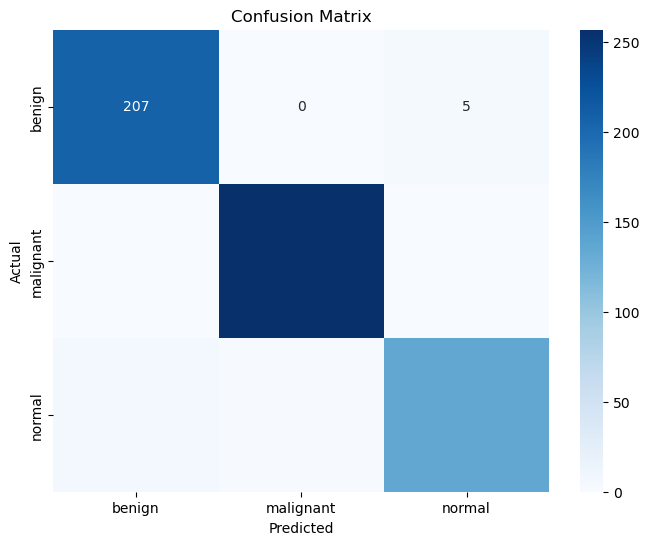

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_metrics(model, data_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Get class names from dataset
class_names = train_dataset.classes  # Assuming class names are the same across datasets

evaluate_metrics(model, test_loader, class_names)


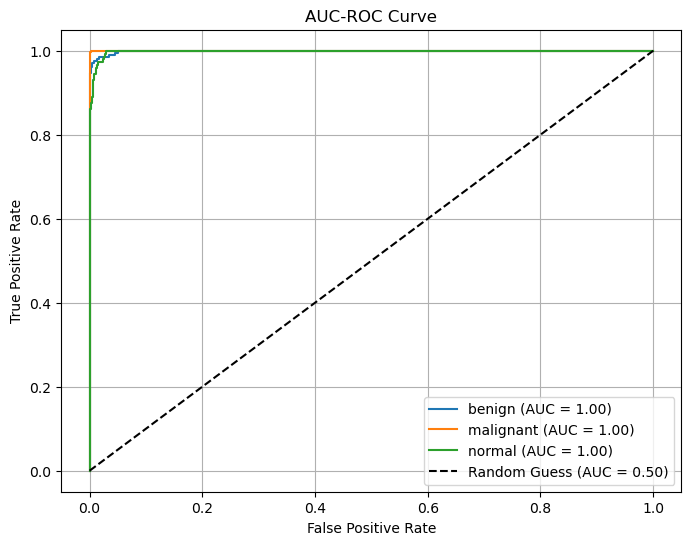

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

def plot_roc_auc(model, data_loader, class_names):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Get raw model outputs (logits)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Convert to probabilities
            
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())

    # Convert y_true to one-hot encoding
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

    # Convert y_scores to numpy array
    y_scores = np.array(y_scores)

    plt.figure(figsize=(8, 6))

    # Compute ROC curve and AUC for each class
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

    # Plot diagonal reference line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")

    # Graph details
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Call the function to plot AUC-ROC Curve
plot_roc_auc(model, test_loader, class_names)


In [7]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained DenseNet121 model
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier.in_features

# Define the same classifier used during training
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 3)  # 3 classes: Benign, Malignant, Normal
)

# Load the trained weights
model.load_state_dict(torch.load("best_densenet_model.pth", map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


image_path = r"C:\Users\HP\Documents\major_project\Data_set\final_datasets\final_datasetsssss\test\benign\image_336.png"

# Open the image
image = Image.open(image_path).convert("RGB")

# Apply transformations
image = transform(image).unsqueeze(0).to(device)  # Add batch dimension


# Perform inference
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

# Define class names
class_names = ["Benign", "Malignant", "Normal"]

# Get predicted class
predicted_class = class_names[predicted.item()]
print(f"Predicted Class: {predicted_class}")


C:\Users\HP\AppData\Local\Temp\ipykernel_18264\857861389.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_densenet_model.pth", map

Predicted Class: Benign
